In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from Backtesting import stats

In [2]:
def signal_generation(asset1, asset2, window):    
    
    signals = pd.DataFrame()
    signals['asset1'] = asset1['Close']
    signals['asset2'] = asset2['Close']
    signals['positions1'] = 0.0  
    signals['positions2'] = 0.0
    signals['current'] = np.nan
    signals['upper'] = np.nan
    signals['lower'] = np.nan
    signals['ratio'] = np.nan
    
    for i in range(window,len(signals)):

        # Check for loss of cointegration
        if sm.tsa.stattools.coint(signals['asset1'].iloc[i-window:i], signals['asset2'].iloc[i-window:i])[1] < 0.05:
            
            # Use asset price ratio as measure for signal generation
            signals.at[signals.index[i], 'ratio'] = signals['asset1'].iloc[i]/signals['asset2'].iloc[i]

            moving_average = np.mean(signals['ratio'].iloc[i-window:i])
            standard_dev = np.std(signals['ratio'].iloc[i-window:i])
            current_ratio = np.mean(signals['ratio'].iloc[i-5:i])
            if standard_dev == 0:
                continue
            signals.at[signals.index[i], 'current'] = current_ratio
            signals.at[signals.index[i], 'upper'] = moving_average + standard_dev
            signals.at[signals.index[i], 'lower'] = moving_average - standard_dev
            z_score = (current_ratio - moving_average)/standard_dev

            # Short bullish stock and long bearish one, and vice versa
            if z_score > 1.0:
                signals.at[signals.index[i],'positions1'] = -1
                signals.at[signals.index[i],'positions2'] = current_ratio
            elif z_score < -1.0:
                signals.at[signals.index[i],'positions1'] = 1
                signals.at[signals.index[i],'positions2'] = -current_ratio
            elif abs(z_score) < 0.2:
                signals.at[signals.index[i],'positions1'] = 0
                signals.at[signals.index[i],'positions2'] = 0

    signals['signals1'] = signals['positions1'].diff()
    signals['signals2'] = signals['positions2'].diff()
    signals['signals'] = signals['signals1'] * 2
    signals['positions'] = signals['positions1'] * 2
    
    return signals

In [3]:
def plot(signals, ticker1, ticker2):

    # Long/short signals
    fig = plt.figure(figsize=(11,7))
    ax = fig.add_subplot(111)  
    ax2 = ax.twinx()
    asset1_price, = ax.plot(signals['asset1'], c='C0', alpha=0.8)
    asset2_price, = ax2.plot(signals['asset2'], c='C1', alpha=0.8)
    long, = ax2.plot(signals['asset2'][signals['signals2']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6)
    short, = ax2.plot(signals['asset2'][signals['signals2']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6)
    long, = ax.plot(signals['asset1'][signals['signals1']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6)
    short, = ax.plot(signals['asset1'][signals['signals1']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6)
    ax.set_ylabel(ticker1, labelpad=15)
    ax2.set_ylabel(ticker2, rotation=270, labelpad=15)
    ax.set_xlabel('Date', labelpad=15)
    
    plt.legend([asset1_price, asset2_price, long, short], [ticker1, ticker2, 'LONG','SHORT'], loc='upper left')
    plt.title('Pair Trading', pad=15)
    plt.grid(True)
    plt.show()

    # Running ratio
    plt.figure(figsize=(11,7))
    plt.plot(signals['current'], label='Ratio', alpha=0.8, color='C0')
    plt.fill_between(signals.index, signals['upper'], signals['lower'], alpha=0.2, color='C1', label='1 Sigma')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker1 + '/' + ticker2, labelpad=15)
    plt.legend(loc="upper left")
    plt.title('Pair Trading', pad=15)
    plt.grid(True)
    plt.show()

In [4]:
def portfolio(signals, capital):
    portfolio = pd.DataFrame()
    portfolio['holdings1'] = signals['positions1'] * signals['asset1']
    portfolio['holdings2'] = signals['positions2'] * signals['asset2']

    # Position size to maintain 50% short position margin requirement
    positions = -2 * capital/(min(min(portfolio['holdings1']), min(portfolio['holdings2'])))
    portfolio['holdings1'] *= positions
    portfolio['holdings2'] *= positions
    portfolio['holdings'] = portfolio['holdings1'] + portfolio['holdings2']
    portfolio['cash'] = capital - (signals['signals1'] * signals['asset1'] * positions).cumsum() - (signals['signals2'] * signals['asset2'] * positions).cumsum()
    portfolio['total'] = portfolio['holdings1'] + portfolio['holdings2'] + portfolio['cash']
    portfolio['return'] = portfolio['total'].pct_change()
    
    plt.figure(figsize=(11,7))
    plt.plot(portfolio['total'], alpha=0.8, label="Total Assets")
    plt.xlabel('Date', labelpad=15)
    plt.ylabel('Value ($)', labelpad=15)
    plt.legend(loc="upper left")
    plt.title('Pair Trading', pad=15)
    plt.grid(True)
    plt.show()

    print(portfolio['total'].iloc[-1])

    return portfolio


In [5]:
def PairTrade(ticker1, ticker2, start_date, end_date, capital):
    asset1 = yf.download(ticker1, start=start_date, end=end_date, progress=False)
    asset2 = yf.download(ticker2, start=start_date, end=end_date, progress=False)
    
    # Default window of size 100
    signals = signal_generation(asset1, asset2, 100)
    
    plot(signals, ticker1, ticker2)

    return stats(portfolio(signals, capital), signals, start_date, end_date, capital)

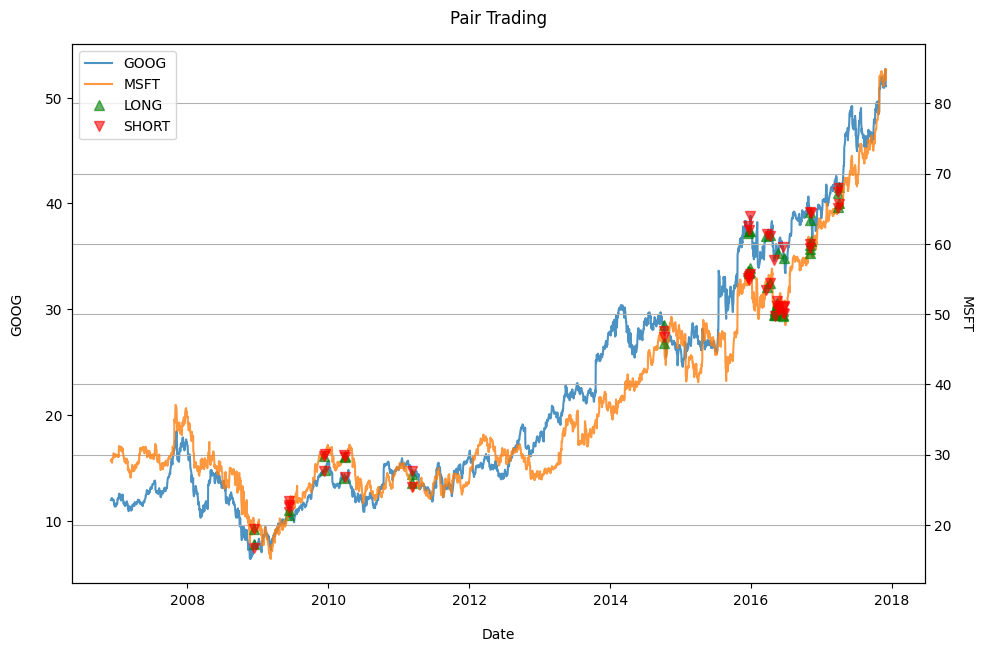

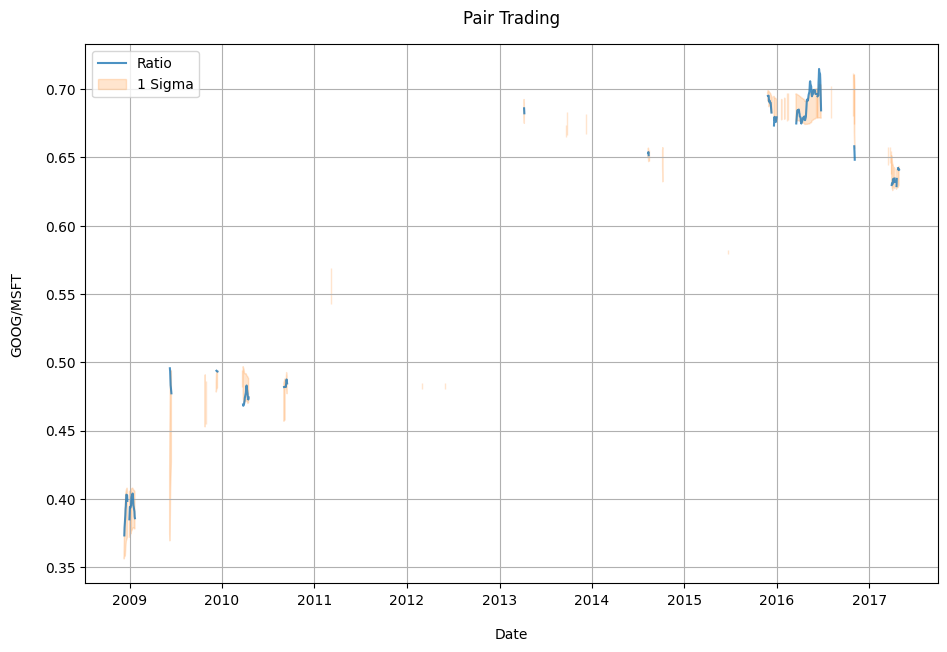

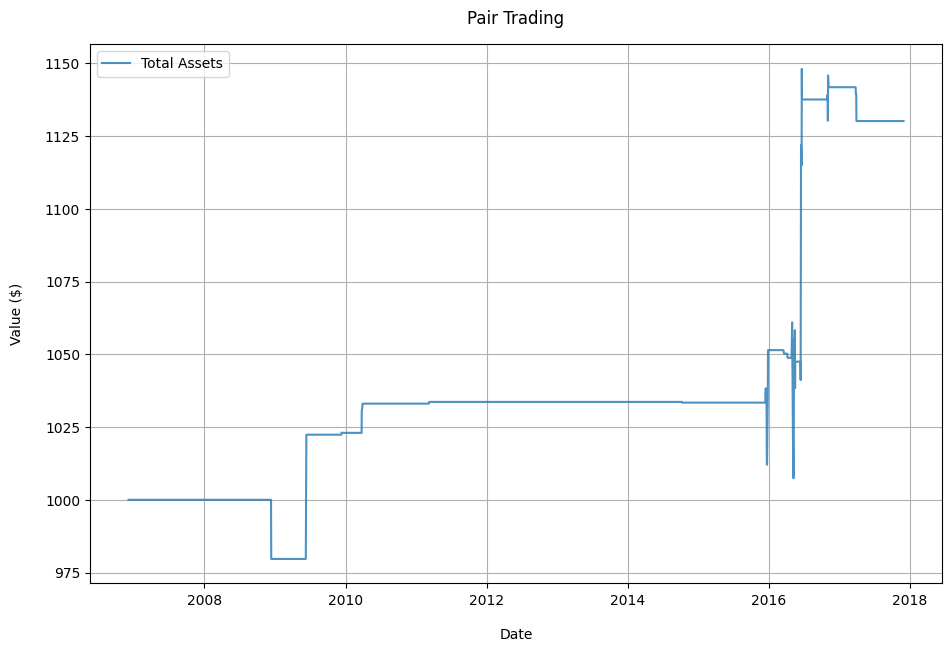

1130.1835284137119


,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.130184,0.890278,0.000044,-0.104435,-0.050509,-0.000875,1.264706,3.828927


In [6]:
PairTrade('GOOG', 'MSFT', '2006-12-01', '2017-12-01', 1000)